# Summary of avg velocity per run - one run

This notebooks takes output from ```ADV_data_01_process_vXX.ipynb``` and performs analysis on the profile data. 

Needs:
- a file called ```summary_velocity_mean.csv``` which is the natural output of the above referenced notebook
- a file called ```summary_coniditions_locations.csv``` to provide spatial information for the 

User input:
- Data folder
- Run to analyze
- Profile $x$ location

Version/Change log:
- V02: uses the profile summary data from  

## Loads

In [1]:
# %pylab inline
import numpy as np
from numpy import log, sin, cos, exp, tan, pi
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

%matplotlib inline
%config InlineBackend.figure_format='retina' # hig-res plots for a Retina display, uncomment while working

# uncomment the two lines below when exporting to a pdf
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('png','pdf')

#returns the clear-water density in kg/m^3 as a function of temperature [in deg C] and salinity [ppt]
def rho_cw(T,S): 
    rho_fresh=1000*(1-(T +288.9414)/(508929.2*(T+68.12963))*(T-3.9863)**2)
    Acoef = 0.824493 - 0.0040899*T + 0.000076438*T**2 -0.00000082467*T**3 + 0.0000000053675*T**4
    Bcoef = -0.005724 + 0.00010227*T - 0.0000016546*T**2
    return rho_fresh + Acoef*S + Bcoef*S**(3/2) + 0.00048314*S**2 

# returns the clear water kinimatic viscosity in [m^2/s] as a function of temperature [in deg C].
def visc(T):
    return 2.7488e-07+1.4907e-06*exp(-0.034812*T)

## User input

In [2]:
datadir = 'Leviathan_ADV/' # path to the data

profilex = 5.12 # x location in meters where the velocity profile is located

T = 10 # water temperature in deg C

## Find and load the data

In [3]:
veldatafile = 'summary_velocity_mean.csv'
conditionlocationfile = 'summary_coniditions_locations.csv'
profiledata = 'summary_profile_anal_all.csv'

fig_folder = 'Figures'
# Make the output folder
if os.path.isdir(fig_folder) != 1:
    os.mkdir(fig_folder)

data = pd.read_csv(datadir+veldatafile) # reads in the data
info = pd.read_csv(datadir+conditionlocationfile) # reads in the data
profiles = pd.read_csv(datadir+profiledata)

# add columns to info dataframe 
info.insert(loc=1,column='Run',value=info.File.str[0:5])
info.insert(loc=2,column='Point',value=info.File.str[6:8].astype(int))
info.insert(loc=4,column='S',value=info.S_p/100)

display(data)
display(info)
display(profiles)

,Run,Point,uavg_m_s,vavg_m_s,wavg_m_s,uu_bar,uv_bar,uw_bar,vv_bar,vw_bar,ww_bar,snr1,snr2,snr3,snr4,cor1,cor2,cor3,cor4
0,Run1A,1,0.446311,-0.005856,0.000261,0.015692,-0.002136,-0.004186,0.004395,0.001153,0.006809,18.561677,21.009829,15.775023,15.777187,80.939585,81.356177,80.165014,79.547340
1,Run1A,2,0.531745,-0.000536,0.005418,0.014784,-0.000970,-0.004217,0.003600,0.000349,0.006246,18.563622,20.993034,15.794118,15.781192,82.606037,83.143189,78.359133,81.285604
2,Run1A,3,0.574551,0.004855,0.006886,0.012619,-0.000338,-0.003326,0.003292,0.000170,0.005417,18.568747,21.002209,15.788736,15.770900,83.122032,83.889564,80.963556,81.380453
3,Run1A,4,0.651582,0.011667,0.012566,0.010278,-0.000968,-0.002251,0.003164,0.000067,0.004654,18.557332,20.992933,15.786837,15.760292,84.601148,85.395318,83.537544,82.906360
4,Run1A,5,0.705396,0.019406,0.027665,0.007913,-0.000715,-0.001531,0.002538,0.000125,0.003520,18.563939,21.000722,15.806057,15.761211,85.926996,85.977537,84.297633,85.241075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,Run3D,7,0.963565,0.011280,0.024685,0.021461,-0.001419,-0.004337,0.006090,0.000621,0.006776,18.272326,21.120698,15.844419,15.463256,79.955814,79.972093,79.479070,77.416279
125,Run3D,8,1.086328,0.000426,-0.028907,0.014847,-0.001871,-0.002706,0.004595,0.000409,0.005930,18.270208,21.117188,15.845000,15.453437,80.079167,80.361458,79.139583,78.234375
126,Run3D,9,1.147936,0.002500,-0.055807,0.014264,-0.001289,-0.002672,0.003528,0.000466,0.005500,18.259456,21.107163,15.839398,15.440688,79.713467,79.659026,78.935530,77.928367
127,Run3D,10,1.200596,-0.017846,-0.076234,0.014336,-0.000044,-0.001346,0.004005,0.001346,0.005126,18.268269,21.100641,15.816987,15.427885,77.724359,77.608974,78.041667,76.147436


,File,Run,Point,Q_cms,S,S_p,T_cm,x_m,h_cm,z_cm,air,notes
0,Run1A_01.dat,Run1A,1,0.099,0.0050,0.50,7.8,5.12,12.5,1.7,0.0,NaN
1,Run1A_02.dat,Run1A,2,0.099,0.0050,0.50,7.8,5.12,12.5,2.7,0.0,NaN
2,Run1A_03.dat,Run1A,3,0.099,0.0050,0.50,7.8,5.12,12.5,3.7,0.0,NaN
3,Run1A_04.dat,Run1A,4,0.099,0.0050,0.50,7.8,5.12,12.5,5.7,0.0,NaN
4,Run1A_05.dat,Run1A,5,0.099,0.0050,0.50,7.8,5.12,12.5,7.7,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
123,Run3D_07.dat,Run3D,7,0.139,0.0075,0.75,8.0,4.00,11.4,4.5,0.0,NaN
124,Run3D_08.dat,Run3D,8,0.139,0.0075,0.75,8.0,3.85,8.9,3.1,0.0,NaN
125,Run3D_09.dat,Run3D,9,0.139,0.0075,0.75,8.0,3.70,7.8,2.1,1.0,NaN
126,Run3D_10.dat,Run3D,10,0.139,0.0075,0.75,8.0,3.50,8.0,2.5,1.0,NaN


,Run,Q_cms,S,T_cm,x_m,h_cm,uavg_m_s,Q_Uavg_cms,ks_m,ustar_profile_m_s,ustar_ds_m_s,ustar_uw_m_s,f_ds,f_profile,f_uw,taub_profile_Pa,taub_ds_Pa,taub_uw_Pa
0,Run1A,0.099,0.0050,7.8,5.12,12.5,0.644326,0.096649,0.035298,0.067088,0.071233,0.071376,0.097778,0.086729,0.098170,4.499530,5.072758,5.093111
1,Run1B,0.113,0.0050,7.8,5.12,12.8,0.713940,0.109661,0.038353,0.076286,0.071934,0.065963,0.081215,0.091338,0.068291,5.817932,5.173099,4.349887
2,Run1C,0.126,0.0050,7.8,5.12,14.5,0.720280,0.125329,0.039555,0.077388,0.075683,0.076782,0.088326,0.092349,0.090909,5.987269,5.726429,5.893851
3,Run1D,0.139,0.0050,7.8,5.12,15.4,0.778132,0.143799,0.057157,0.092721,0.077530,0.078811,0.079419,0.113590,0.082065,8.594847,6.009268,6.209521
4,Run2A,0.100,0.0075,8.0,5.12,11.7,0.712806,0.100078,0.078364,0.096083,0.084874,0.072840,0.113421,0.145357,0.083538,9.229371,7.201619,5.304167
5,Run2B,0.113,0.0075,8.0,5.12,12.2,0.751688,0.110047,0.081397,0.101848,0.086368,0.089002,0.105613,0.146865,0.112155,10.370180,7.457376,7.919269
6,Run2C,0.127,0.0075,8.0,5.12,13.3,0.866392,0.138276,0.160807,0.155544,0.089498,0.102334,0.085367,0.257850,0.111610,24.187277,8.007761,10.469443
7,Run2D,0.139,0.0075,8.0,5.12,14.9,0.837564,0.149756,0.125532,0.128349,0.093712,0.091333,0.100147,0.187862,0.095128,16.468955,8.779461,8.339448
8,Run3A,0.099,0.0075,8.0,5.12,10.4,0.800591,0.099914,0.121024,0.133723,0.080755,0.093406,0.081397,0.223194,0.108897,17.877080,6.519647,8.722230
9,Run3B,0.112,0.0075,8.0,5.12,12.0,0.857936,0.123543,0.101684,0.128575,0.085776,0.096205,0.079967,0.179678,0.100595,16.527075,7.355500,9.252943


## Runs available

In [4]:
runs = info.Run.unique()
runs

array(['Run1A', 'Run1B', 'Run1C', 'Run1D', 'Run2A', 'Run2B', 'Run2C',
       'Run2D', 'Run3A', 'Run3B', 'Run3C', 'Run3D'], dtype=object)

## Define the run, depth avg the profile and combine that average values

Uses the user input of the profile location and run to pull out data from the two ```.csv``` files and create a new ```profile``` dataframe to work with

,File,Q_cms,S,S_p,T_cm,x_m,h_cm,z_cm,air,notes,Run,Point,uavg_m_s,Fr_local,tau_b_Pa
0,Run1C_12.dat,0.126,0.005,0.5,7.8,2.61,14.2,4.5,NaN,no notes on air,Run1C,12,0.535110,0.453382,3.252986
1,Run1C_11.dat,0.126,0.005,0.5,7.8,3.50,14.0,4.5,NaN,no notes on air,Run1C,11,-0.204464,-0.174469,0.474930
2,Run1C_10.dat,0.126,0.005,0.5,7.8,3.70,5.6,1.6,NaN,no notes on air,Run1C,10,NaN,NaN,NaN
3,Run1C_09.dat,0.126,0.005,0.5,7.8,3.85,5.0,0.8,NaN,no notes on air,Run1C,9,0.840584,1.200222,8.027101
4,Run1C_08.dat,0.126,0.005,0.5,7.8,4.00,10.0,3.9,NaN,no notes on air,Run1C,8,0.703923,0.710708,5.629209
5,Run1C_07.dat,0.126,0.005,0.5,7.8,4.10,14.3,6.8,NaN,no notes on air,Run1C,7,0.674552,0.569526,5.169254
6,depth avg,0.126,0.005,0.5,7.8,5.12,14.5,NaN,NaN,NaN,Run1C,DepthAvg,0.720280,0.603925,5.893851


Depth average vel, Uavg [m/s] = 0.72
Max vel over nest, Unest [m/s] =0.84
Unest - Uavg [m/s] = 0.12


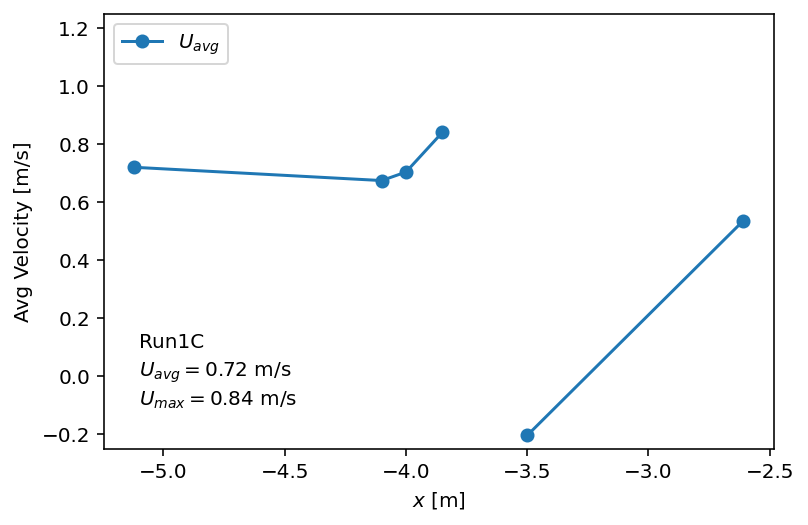

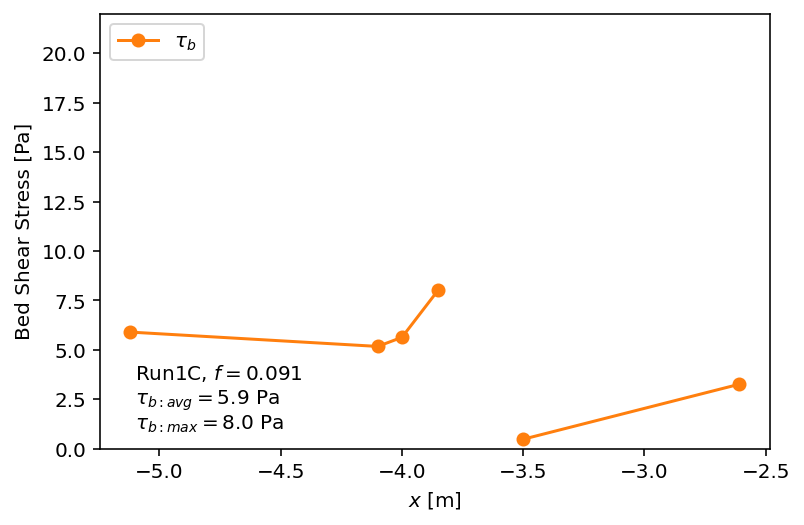

In [6]:
""" --- User input ----------------------------- """

run = 'Run1C'

"""  ------------------------------------------- """

rho = rho_cw(T,0)
output_path=datadir+'/summary_vel_x_'+run+'.csv'

# pull the profile data ------------------

profile_summary = profiles[(profiles.Run == run)]
profile_summary = profile_summary.loc[:, :'uavg_m_s']
profile_summary['S_p']=profile_summary.S*100
profile_summary['File']='depth avg'
profile_summary['Point']='DepthAvg'

Uavg = profile_summary.uavg_m_s.iloc[0]
f=profiles[(profiles.Run == run)].f_uw.iloc[0]

# pull the non profile data ------

npinfo = info[(info.Run == run)&(info.x_m != profilex)].copy() # pull out the non profile for the run
npinfo = npinfo.sort_values(by=['Point']).reset_index(drop=True) # sort the data on the points in case something is out of order

npfirst = npinfo.Point.min() # define which points are part of the profile - the first
nplast = npinfo.Point.max()  # define which points are part of the profile - the last
npdata = data[(data.Run == run)&(data.Point >= npfirst)&(data.Point <= nplast)].copy() # pull out the profile for the run
npdata = npdata.sort_values(by=['Point']).reset_index(drop=True)   # sort the data on the points in case something is out of order

# drop data in the combine... 
npinfo = npinfo.drop(columns=['Run','Point'])
npdata = npdata.drop(columns=['snr1','snr2','snr3','snr4','cor1','cor2','cor3','cor4'])
npdata = npdata.drop(columns=['uu_bar','uv_bar','uw_bar','vv_bar','vw_bar','ww_bar'])
npdata = npdata.drop(columns=['vavg_m_s','wavg_m_s'])

summary = pd.concat([npinfo,npdata], axis=1)
# summary = summary.append(profile_summary)
summary = pd.concat((summary, profile_summary), axis = 0)
summary = summary.sort_values(by=['x_m']).reset_index(drop=True)

summary['Fr_local']=summary.uavg_m_s/np.sqrt(9.81*summary.h_cm/100)
summary['tau_b_Pa'] = (f/8)*rho*summary.uavg_m_s**2

summary.to_csv(output_path, index=False)
display(summary)

UAVGstr = str(np.around(Uavg, decimals=2))
Umax = str(np.around(summary.uavg_m_s.max(), decimals=2))

taub_ambient = str(np.around((f/8)*rho*profile_summary.uavg_m_s.iloc[0]**2,decimals=1))
taub_max = str(np.around(max(summary.tau_b_Pa),decimals=1))
fric = str(np.around(f,decimals=3))

print('Depth average vel, Uavg [m/s] = '+UAVGstr)
print('Max vel over nest, Unest [m/s] ='+Umax)
print('Unest - Uavg [m/s] =', np.around(summary.uavg_m_s.max()-Uavg , decimals=2))

fig, ax = plt.subplots()
ax.plot(-summary.x_m,summary.uavg_m_s, 'o-', alpha=1, label='$U_{avg}$')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('Avg Velocity [m/s]')
ax.set_ylim(-0.25,1.25)
ax.text(-5.1,-0.0, '$U_{avg} = $'+UAVGstr+' m/s', backgroundcolor='none', 
        clip_on='True', multialignment='center', alpha=1) #weight = 'bold', 
ax.text(-5.1,-0.1, '$U_{max} = $'+Umax+' m/s', backgroundcolor='none', 
        clip_on='True', multialignment='center', alpha=1) #weight = 'bold', 
ax.text(-5.1,0.1, run, backgroundcolor='none', clip_on='True', multialignment='center', alpha=1) #weight = 'bold', 
plt.legend(loc=2, ncol=1)
plt.savefig(fig_folder+'/'+run+'_U(x).pdf',bbox_inches="tight", pad_inches=0.005)

fig, ax = plt.subplots()
ax.plot(-summary.x_m,summary.tau_b_Pa, 'o-', color='C1', alpha=1, label=r'$\tau_{b}$')
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('Bed Shear Stress [Pa]')
ax.set_ylim(0,22)
ax.text(-5.1,3.5, run+', $f=$'+fric, backgroundcolor='none', clip_on='True', multialignment='center', alpha=1) #weight = 'bold', 
ax.text(-5.1,2.25, r'$\tau_{b:avg} = $'+taub_ambient+' Pa', backgroundcolor='none', 
        clip_on='True', multialignment='center', alpha=1) #weight = 'bold', 
ax.text(-5.1,1.0, r'$\tau_{b:max} = $'+taub_max+' Pa', backgroundcolor='none', 
        clip_on='True', multialignment='center', alpha=1) #weight = 'bold', 
plt.legend(loc=2, ncol=1)
plt.savefig(fig_folder+'/'+run+'_tau(x).pdf',bbox_inches="tight", pad_inches=0.005)